In [46]:
!pip install keras
!pip install tensorflow
!pip install pyyaml h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [47]:
import numpy as np
import pandas as pd
import tensorflow as tf
import re
# sklearn imports
from sklearn.model_selection import train_test_split
# keras/tensorflow imports
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Multiply, Concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adagrad, Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model

# visualization imports
import matplotlib.pyplot as plt
%matplotlib inline

**Reading the dataset**

In [48]:
!wget -nc http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip -n ml-100k.zip

File ‘ml-100k.zip’ already there; not retrieving.

Archive:  ml-100k.zip


In [49]:
ratings = ['userId','movieId','rating','timestamp']
df_ratings = pd.read_csv('ml-100k/u.data', sep='\t',header=None,names= ratings)
df_products = pd.read_csv('ml-100k/u.item', sep='|',header=None, encoding='latin-1')

In [50]:
df_movies=pd.DataFrame()
df_movies['movieId']=df_products[0]
df_movies['title']=df_products[1]
print(df_movies.head())
print(df_movies.shape)
print(max(df_movies['movieId']))

   movieId              title
0        1   Toy Story (1995)
1        2   GoldenEye (1995)
2        3  Four Rooms (1995)
3        4  Get Shorty (1995)
4        5     Copycat (1995)
(1682, 2)
1682


In [51]:
num_users = len(df_ratings.userId.unique())
num_items = len(df_ratings.movieId.unique())
print('There are {} unique users and {} unique movies in this data set'.format(num_users, num_items))

There are 943 unique users and 1682 unique movies in this data set


In [52]:
user_maxId = df_ratings.userId.max()
item_maxId = df_ratings.movieId.max()
print('There are {} distinct users and the max of user ID is also {}'.format(num_users, user_maxId))
print('There are {} distinct movies, however, the max of movie ID is {}'.format(num_items, item_maxId))
print('In the context of matrix factorization, the current item vector is in unnecessarily high dimensional space')
print('So we need to do some data cleaning to reduce the dimension of item vector back to {}'.format(num_items))

There are 943 distinct users and the max of user ID is also 943
There are 1682 distinct movies, however, the max of movie ID is 1682
In the context of matrix factorization, the current item vector is in unnecessarily high dimensional space
So we need to do some data cleaning to reduce the dimension of item vector back to 1682


In [53]:
def reduce_item_dim(df_ratings):
    """
    Reduce item vector dimension to the number of distinct items in our data sets
    
    input: pd.DataFrame, df_ratings should have columns ['userId', 'movieId', 'rating']
    output: pd.DataFrame, df_ratings with new 'MovieID' that is compressed
    """
    # pivot
    df_user_item = df_ratings.pivot(index='userId', columns='movieId', values='rating')
    # reset movieId
    df_user_item = df_user_item.T.reset_index(drop=True).T
    # undo pivot/melt - compress data frame
    df_ratings_new = df_user_item \
        .reset_index('userId') \
        .melt(
            id_vars='userId', 
            value_vars=df_user_item.columns,
            var_name='movieId',
            value_name='rating')
    # drop nan and final clean up
    return df_ratings_new.dropna().sort_values(['userId', 'movieId']).reset_index(drop=True)

In [54]:
print('reduce item dimension before:')
print(df_ratings.head())
df_ratings.shape

reduce item dimension before:
   userId  movieId  rating  timestamp
0     196      242       3  881250949
1     186      302       3  891717742
2      22      377       1  878887116
3     244       51       2  880606923
4     166      346       1  886397596


(100000, 4)

In [55]:
df_ratings = reduce_item_dim(df_ratings)
print('reduce item dimension after:')
df_ratings.head()

reduce item dimension after:


,userId,movieId,rating
0,1,0,5.0
1,1,1,3.0
2,1,2,4.0
3,1,3,3.0
4,1,4,3.0


**Model configuration**

In [56]:
def get_MLP_model(num_users, num_items, layers, reg_layers):
    """
    Build Multi-Layer Perceptron Model Topology
    
    Parameters
    ----------
    num_users: int, total number of users
    num_iterms: int, total number of items
    layers: list of int, each element is the number of hidden units for each layer,
        with the exception of first element. First element is the sum of dims of
        user latent vector and item latent vector
    reg_layers: list of int, each element is the L2 regularization parameter for
        each layer in MLP

    Return
    ------
    A Keras Model with MLP model architeture
    """
    assert len(layers) == len(reg_layers)
    num_layer = len(layers) # Number of layers in the MLP
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    item_input = Input(shape=(1,), dtype='int32', name='item_input')

    MLP_Embedding_User = Embedding(
        input_dim=num_users + 1,
        output_dim=layers[0] // 2,
        embeddings_initializer='uniform',
        name='user_embedding',
        embeddings_regularizer=l2(reg_layers[0]),
        input_length=1)
    MLP_Embedding_Item = Embedding(
        input_dim=num_items + 1,
        output_dim=layers[0] // 2,
        embeddings_initializer='uniform',
        name='item_embedding',
        embeddings_regularizer=l2(reg_layers[0]),
        input_length=1) 
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MLP_Embedding_User(user_input))
    item_latent = Flatten()(MLP_Embedding_Item(item_input))

    # The 0-th layer is the concatenation of embedding layers
    vector = Concatenate(axis=-1)([user_latent, item_latent])

    # MLP layers
    for idx in range(1, num_layer):
        layer = Dense(
            units=layers[idx],
            activation='relu',
            kernel_initializer='glorot_uniform',
            kernel_regularizer=l2(reg_layers[idx]),
            name = 'layer%d' %idx)
        vector = layer(vector)
    
    # Final prediction layer
    prediction = Dense(1, kernel_initializer='glorot_uniform', name='prediction')(vector)
    
    # Stitch input and output
    model = Model([user_input, item_input], prediction)
    
    return model

**Training the model**

In [57]:
def train_model(model, learner, batch_size, epochs, val_split, inputs, outputs):
    """
    define training routine, train models and save best model
    
    Parameters
    ----------
    model: a Keras model
    learner: str, one of ['sgd', 'adam', 'rmsprop', 'adagrad']
    batch_size: num samples per update
    epochs: num iterations
    val_split: split ratio for validation data
    inputs: inputs data
    outputs: outputs data
    """
    # add customized metric
    def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_true - y_pred)))
    
    # compile model
    model.compile(optimizer=learner.lower(), loss='mean_squared_error', metrics=['mean_squared_error', rmse])
    
    # add call backs
    early_stopper = EarlyStopping(monitor='val_rmse', patience=10, verbose=1)
    model_saver = ModelCheckpoint(filepath= 'model.hdf5',
                                  monitor='val_rmse',
                                  save_best_only=True,
                                  save_weights_only=True)
    print("FITTING THE DATA")
    # train model
    print(model)
    history = model.fit(x=inputs, y=outputs,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_split=val_split,
                        callbacks=[early_stopper, model_saver])
    return history


def load_trained_model(model, weights_path):
    model.load_weights(weights_path)
    return model

In [58]:
def rmse(test_rating,predictions):
   return np.sqrt(np.mean((predictions-test_rating)**2))


In [59]:
def plot_learning_curve(history, metric):
    
    # Plot learning curve to compare training error vs. validation error
    
    # get training error
    errors = history.history[metric]
    # get validation error
    val_errors = history.history['val_{}'.format(metric)]
    # get epochs
    epochs = range(1, len(errors) + 1)

    # plot
    plt.figure(figsize=(12, 7))
    plt.plot(epochs, errors, 'bo', label='training {}'.format(metric))
    plt.plot(epochs, val_errors, 'b', label='validation {}'.format(metric))
    plt.xlabel('number of epochs')
    plt.ylabel(metric)
    plt.title('Model Learning Curve')
    plt.grid(True)
    plt.legend()
    plt.show()

**Train - Test Split**

In [67]:
import pandas as pd

# data config
DATAPATH = 'ml-100k/u.data'
MODELPATH = 'model.hdf5'
TEST_SIZE = 0.25

# model config
EMBEDDED_DIM = 10
L2_REG = 0


# trainer config
OPTIMIZER = 'adam'
BATCH_SIZE = 64
EPOCHS = 30
VAL_SPLIT = 0.25

# load ratings
ratings = ['userId','movieId','rating','timestamp']
df_ratings = pd.read_csv('ml-100k/u.data', sep='\t',header=None,names= ratings)

# get total number of users and items
num_users = len(df_ratings.userId.unique())
num_items = len(df_ratings.movieId.unique())
print(df_ratings)
# train/test split
df_train, df_test = train_test_split(df_ratings, test_size=0.25, shuffle=True, random_state=99)

inputs =[df_train.userId.values.astype('float32'), df_train.movieId.values.astype('float32')]
o=df_train.rating.values
outputs=tf.convert_to_tensor(o)
print(inputs,type(inputs))


       userId  movieId  rating  timestamp
0         196      242       3  881250949
1         186      302       3  891717742
2          22      377       1  878887116
3         244       51       2  880606923
4         166      346       1  886397596
...       ...      ...     ...        ...
99995     880      476       3  880175444
99996     716      204       5  879795543
99997     276     1090       1  874795795
99998      13      225       2  882399156
99999      12      203       3  879959583

[100000 rows x 4 columns]
[array([232., 505., 128., ...,  70., 399., 523.], dtype=float32), array([ 32.,  66., 499., ...,  88.,  91., 393.], dtype=float32)] <class 'list'>


**Model Instantiation**

In [68]:
# instantiating a model
MLP_model = get_MLP_model(num_users, num_items, [64,32,16,8], [0,0,0,0])
MLP_model.summary()
history = train_model(MLP_model, 'adam', BATCH_SIZE, EPOCHS, VAL_SPLIT,inputs,outputs)
MLP_model = load_trained_model(MLP_model, 'model.hdf5')



Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 item_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 32)        30208       ['user_input[0][0]']             
                                                                                                  
 item_embedding (Embedding)     (None, 1, 32)        53856       ['item_input[0][0]']             
                                                                                            

**Making Predictions using the configured model**

In [69]:
# make prediction using test data
predictions = MLP_model.predict([df_test.userId.values.astype('float32'), df_test.movieId.values.astype('float32')])

# get the RMSE
error = rmse(df_test.rating.values, predictions)
print('The out-of-sample RMSE of rating predictions is', round(error, 4))

782/782 [==============================] - 2s 2ms/step
The out-of-sample RMSE of rating predictions is 1.2919


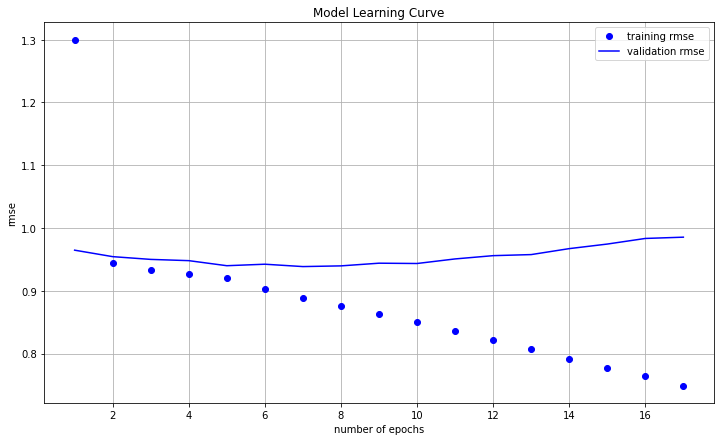

In [18]:
plot_learning_curve(history, 'rmse')

**Creating a sparse matrix movies x users**

In [19]:
#creating sparse matrix
movie_features_df=df_ratings.pivot_table(index='movieId',columns='userId',values='rating').fillna(0)
movie_features_df.head()

userId,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
movieId,,,,,,,,,,,,,,,,,,,,,
1,5.0,4.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,4.0,...,2.0,3.0,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0
2,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,...,5.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
5,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Getting user id to make recommendations**

In [20]:
#Generating a random userId
import random
query=random.randint(1,943)
print("The query user id is ",query)

The query user id is  60


In [70]:
#Reading the user_id from the console
query=input('Input the user id [1 - 1943]\n')
query=int(query)

Input the user id [1 - 1943]
5


In [71]:
query_user=movie_features_df.loc[:,query]
print(query_user.shape)
query_user.to_numpy()
print(query_user.size)

(1682,)
1682


**Recommendation process**

In [72]:
#Finding the unwatched movies (rating =0) by the query user
unwatched = np.where(query_user == 0)
print("No. of unwatched movies is ",len(unwatched[0]))
unwatched

No. of unwatched movies is  1507


(array([   2,    3,    4, ..., 1679, 1680, 1681]),)

In [73]:
unwatched_movies = pd.DataFrame(unwatched)
unwatched_movies=unwatched_movies.T
unwatched_movies.columns=['movieId']

print(type(unwatched_movies))
unwatched_movies['Query_userId'] = query
print("List of unwatchewd movie Ids \n",unwatched_movies)

<class 'pandas.core.frame.DataFrame'>
List of unwatchewd movie Ids 
       movieId  Query_userId
0           2             5
1           3             5
2           4             5
3           5             5
4           6             5
...       ...           ...
1502     1677             5
1503     1678             5
1504     1679             5
1505     1680             5
1506     1681             5

[1507 rows x 2 columns]


In [74]:
#predicting the rating for the unwatched movies
query_pred = MLP_model.predict([unwatched_movies.Query_userId.values.astype('float32'), unwatched_movies.movieId .values.astype('float32')])


48/48 [==============================] - 0s 4ms/step


In [75]:
print(max(query_pred))
print(min(query_pred))

[4.295789]
[0.9700907]


In [76]:
#creating a dataframe with the predicted ratings for the unwatched movies
rat_hat=pd.DataFrame(query_pred)
rat_hat.columns=['rating_hat']

unwatched_movies['ratings_hat']=rat_hat['rating_hat']
print(unwatched_movies.head())
print(unwatched_movies.shape)
#keeping the scale of rating between 1 and 5
unwatched_movies.loc[unwatched_movies['ratings_hat']>5,'ratings_hat'] = 5
unwatched_movies.loc[unwatched_movies['ratings_hat']<1,'ratings_hat'] = 1

   movieId  Query_userId  ratings_hat
0        2             5     2.917938
1        3             5     2.700421
2        4             5     3.252240
3        5             5     2.825223
4        6             5     2.750224
(1507, 3)


In [77]:
#sorting the ratings in descending order
final_df = unwatched_movies.sort_values(by=['ratings_hat'], ascending=False)
print(final_df.head())


      movieId  Query_userId  ratings_hat
676       851             5     4.295789
1192     1367             5     4.215064
1274     1449             5     4.177098
308       483             5     4.174873
238       318             5     4.072565


In [81]:
num_rec=input('How many recommendations you want to make\n')

How many recommendations you want to make
10


In [82]:
i=int(num_rec)
rec_list = final_df.iloc[:i]
print(rec_list)

      movieId  Query_userId  ratings_hat
676       851             5     4.295789
1192     1367             5     4.215064
1274     1449             5     4.177098
308       483             5     4.174873
238       318             5     4.072565
1014     1189             5     4.069124
10         12             5     4.062088
126       169             5     4.058796
85        114             5     4.036878
52         64             5     4.030458


In [83]:
#Recommending the movies
print("Recommendations for user no. ",query," is :\n")
df_movies.loc[df_movies['movieId'].isin(rec_list['movieId'])]['title']


Recommendations for user no.  5  is :



11                             Usual Suspects, The (1995)
63                       Shawshank Redemption, The (1994)
113     Wallace & Gromit: The Best of Aardman Animatio...
168                            Wrong Trousers, The (1993)
317                               Schindler's List (1993)
482                                     Casablanca (1942)
850           Two or Three Things I Know About Her (1966)
1188                                   Prefontaine (1997)
1366                                         Faust (1994)
1448                               Pather Panchali (1955)
Name: title, dtype: object